In [71]:
import sys, os
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt

from simulation.lensing_sim import LensingSim
from simulation.units import *
from astropy.cosmology import Planck15


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from simulation.population_lensing_sim import SubhaloPopulation
from simulation.profiles import MassProfileNFW

In [73]:
from simulation.lensing_observation import LensingObservation

array([[6.66341848e+24, 3.02052000e+24, 1.38719956e+24, ...,
        4.91866573e+22, 1.00104802e+23, 2.06954716e+23],
       [2.82631236e+24, 1.26611509e+24, 5.74561220e+23, ...,
        1.93071909e+22, 3.97817511e+22, 8.32580556e+22],
       [1.21242334e+24, 5.36653908e+23, 2.40587539e+23, ...,
        7.65397157e+21, 1.59708823e+22, 3.38457672e+22],
       ...,
       [2.83900598e+19, 1.04812068e+19, 3.90233405e+18, ...,
        4.11899062e+16, 1.06562845e+17, 2.78679768e+17],
       [5.20549556e+19, 1.94534638e+19, 7.33434622e+18, ...,
        8.30657597e+16, 2.11612368e+17, 5.45228707e+17],
       [9.74339200e+19, 3.68643185e+19, 1.40763897e+19, ...,
        1.71121279e+17, 4.29254082e+17, 1.08959319e+18]])

0.837045110048711 1.8129018913174275 0.6605927631492117 237.69243109625728 1.1582560483743747 0.06770533027259994 -0.1294989415614105 0.07251448952924992 25.039043584873433


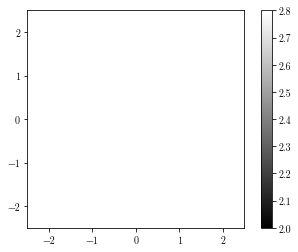

In [270]:
coordinate_limit = 2.5
lo = LensingObservation()

v_min = 2
v_max = 2.8

plt.figure()

plt.imshow(np.log10((lo.image)),
        vmin=v_min,
        vmax=v_max,
        cmap='gist_gray',
        extent=(-coordinate_limit, coordinate_limit,-coordinate_limit, coordinate_limit),
        origin="lower"
)
plt.colorbar()

In [271]:
lo.image

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [61]:
def Msv(sigma_v):
    """ https://arxiv.org/pdf/1804.04492.pdf
    """
    a = 0.09
    b = 3.48

    l10m = a + b * np.log10(sigma_v / (100*Kmps))
    sigma_l10m = 0.13
    l10m = np.random.normal(l10m, sigma_l10m)
    return (10**l10m)*1e12*M_s

def total_flux_adu(mag, mag_zp):
    """
    Returns total flux of the integrated profile, in ADU relative to mag_zp
    """
    return 10**(-0.4 * (mag - mag_zp))

In [50]:
M_hst = Msv(250*Kmps)
c_hst = MassProfileNFW.c_200_SCP(M_hst)
m_min = 1e7*M_s

z_s = 2.
z_l = 0.5

D_s = Planck15.angular_diameter_distance(z=z_s).value * Mpc
D_l = Planck15.angular_diameter_distance(z=z_l).value * Mpc

r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(M_hst, c_hst)

ps = SubhaloPopulation(N_calib=150, M_hst=M_hst, c_hst=c_hst, m_min=m_min, theta_s=r_s/D_l)
ps.n_sub_roi

519

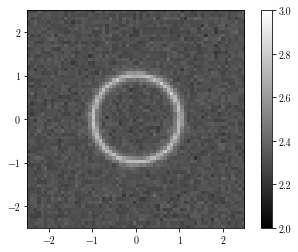

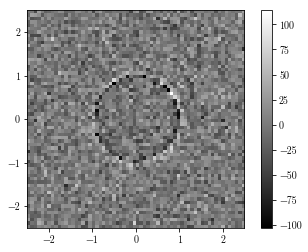

In [42]:
m_sub = ps.m_sample

coordinate_limit = 2.5
exposure = 1610
f_iso = total_flux_adu(22.2, 25.5) 
S_tot = total_flux_adu(25.5, 25.5)

hst_param_dict = {
            "profile": "SIE",
            "theta_x_0": 0.0,
            "theta_y_0": 0.0,
            "theta_E": 1,
            "q": 1,
}

lens_list = [hst_param_dict]

for m in m_sub:
    c = MassProfileNFW.c_200_SCP(m)
    r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(m, c)
    sub_param_dict = {
                "profile": "NFW",
                "theta_x_0": np.random.uniform(-2,2),
                "theta_y_0": np.random.uniform(-2,2),
                "M_200": m,
                "r_s": r_s,
                "rho_s": rho_s
    }

    lens_list.append(sub_param_dict)


observation_dict = {
            "n_x": 64,
            "n_y": 64,
            "theta_x_lims": (-coordinate_limit, coordinate_limit),
            "theta_y_lims": (-coordinate_limit, coordinate_limit),
            "exposure": exposure,
            "f_iso": f_iso,
        }

src_param_dict = {
            "profile": "Sersic",
            "theta_x_0": .01,
            "theta_y_0": .01,
            "S_tot": S_tot,
            "theta_e": 0.1,
            "n_srsc": 1,
        }

global_dict = {"z_s": z_s, "z_l": z_l}

lsi = LensingSim(lens_list, 
                 [src_param_dict], 
                 global_dict, 
                 observation_dict)

image = np.random.poisson(lsi.lensed_image())

v_min = 2
v_max = 3.

plt.figure()

plt.imshow(np.log10(image),
        vmin=v_min,
        vmax=v_max,
        cmap='gist_gray',
        extent=(-coordinate_limit, coordinate_limit,-coordinate_limit, coordinate_limit),
        origin="lower"
)
plt.colorbar()

lsi = LensingSim([lens_list[0]], 
                 [src_param_dict], 
                 global_dict, 
                 observation_dict)

image_hst = np.random.poisson(lsi.lensed_image())

plt.figure()

plt.imshow((image - image_hst),
        cmap='gist_gray',
        extent=(-coordinate_limit, coordinate_limit,-coordinate_limit, coordinate_limit),
        origin="lower"
)
plt.colorbar()

